In [1]:
import matplotlib
matplotlib.use('Agg')

# Get setup

% matplotlib inline 
#plots in the doc

# homebrewed modules
from metro import io            # for reading multiplex
from metro import utility       # for manipulating multiplex
from metro import analysis      # analytical functions
from metro import viz           # for bubble_plot()
from metro import assignment    # for reading and manipulating OD data

# other modules
import warnings                 # suppress ipython warnings
import networkx as nx           # assigning attributes to multiplex
import matplotlib.pyplot as plt # convenience for plotting
import seaborn as sns           # main plotting library
from matplotlib import pylab    # for colormap manipulation
import numpy as np              # math functions
import pandas as pd
import fiona
# preferences across the worksheet
warnings.filterwarnings('ignore') # stops ipython from printing warnings
sns.set_style("white") # nicer background style


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
multi = io.read_multi() # read the prepared multiplex from 2_multiplex/

In [3]:
dists = nx.get_edge_attributes(multi.G, 'dist_km')
times = nx.get_edge_attributes(multi.G, 'free_flow_time_m')

speed_km_m = {key : dists[key]/times[key] for key in dists}

nx.set_edge_attributes(multi.G, 'speed_km_m', speed_km_m)

street_speed = multi.mean_edge_attr_per(layers = ['streets'], attr = 'speed_km_m', weight_attr = 'dist_km')
metro_speed = multi.mean_edge_attr_per(layers = ['metro'], attr = 'speed_km_m', weight_attr = 'dist_km') 

scale = street_speed / metro_speed
print scale

multi.scale_edge_attribute(layer = 'metro', attribute = 'free_flow_time_m', beta = 1/scale)

1.00708756873


In [4]:
G = multi.layers_as_subgraph(['taz', 'streets', 'metro'])
g = utility.nx_2_igraph(G)
od = assignment.od_dict_igraph(g, '1_data/taz_od/0_1.txt')

In [5]:
n_nodes = 50

nodes = od.keys()[:]
# nodes = od.keys()[:n_nodes]

sub_od = {o : od[o] for o in nodes}
# sub_od = {o : {d : od[o][d] for d in nodes} for o in nodes}

In [6]:
betas = [100, 1, .9, .8, .7, .6, .5, .4, .3, .2, .1, 0.01]

In [7]:
for beta in betas:
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'free_flow_time_m', beta = beta)
    assignment.ITA_igraph(g = g, 
                          od = sub_od,
                          attrname = 'congested_time_m_' + str(beta),
                          P = [.1]*10 )
    d = {(g.vs[g.es[i].source]['id'], g.vs[g.es[i].target]['id']) : g.es[i]['congested_time_m_' + str(beta)] for i in range(len(g.es))}
    f = {(g.vs[g.es[i].source]['id'], g.vs[g.es[i].target]['id']) : g.es[i]['flow'] for i in range(len(g.es))}
    
    nx.set_edge_attributes(multi.G, 'congested_time_m_' + str(beta), d)
    nx.set_edge_attributes(multi.G, 'flow_' + str(beta), f)
    
    utility.scale_edge_attribute_igraph(g, layer = 'metro', attr = 'free_flow_time_m', beta = 1/beta)

assigning for p = 0.1
assignment for p = 0.1 completed in 3.2m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.2m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.2m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.2m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.2m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.2m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.2m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.3m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.3m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.3m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.1m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.0m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.0m
assigning for p = 0.1
assignment for p = 0.1 completed in 3.0m
assigning for p = 0.1
assignment for p = 0.1 completed in 2.9m
assigning for p = 0.1
assignment for p = 0.1 completed 

In [8]:
def flow_plot(beta,ax):
    
    cmap = 'plasma'

    fig.set_facecolor("#000000")
    ax.set_axis_bgcolor((0, 0, 0))

    H = multi.layers_as_subgraph(['streets'])

    H.position = {n : (H.node[n]['lon'], H.node[n]['lat']) for n in H}
    H.colors = [H.edge[e[0]][e[1]]['flow_' + str(beta)] / H.edge[e[0]][e[1]]['capacity'] for e in H.edges_iter()]
    H.widths = [H.edge[e[0]][e[1]]['flow_' + str(beta)] * .0005 for e in H.edges_iter()]
    nx.draw_networkx_edges(H, H.position, 
               edge_color=H.colors, 
               arrows = False,
               edge_size = 100,
               edge_cmap = plt.get_cmap(cmap),
               ax = ax,
               width = H.widths,
               node_size = 0,
               edge_vmin = 0, 
               edge_vmax = 1.5,
               alpha = 1)

    nx.draw_networkx_edges(H, H.position,
           edge_color = 'white',
           arrows = False,
           edge_size = 10,
           ax = ax,
           node_size = 0,
           alpha = .15)

    M = multi.layers_as_subgraph(['metro'])
    M.position = {n : (M.node[n]['lon'], M.node[n]['lat']) for n in M}
    M.widths = [M.edge[e[0]][e[1]]['flow_' + str(beta)] * .0003 + 2 for e in M.edges_iter()]

    nx.draw_networkx_edges(M, M.position,
            edge_color = 'white', 
            width = M.widths,
            node_size = 0,
            alpha = .5,
            with_labels = False,
            arrows = False,
            ax = ax)

    ax.set(xlim = xlim, ylim = ylim)

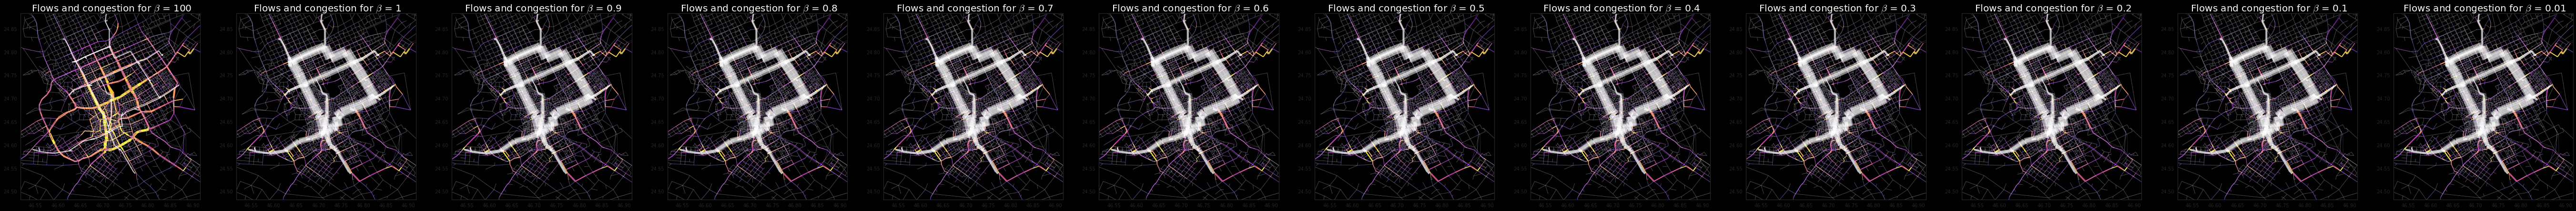

In [9]:
n = len(betas)

pylab.rcParams['savefig.facecolor'] = 'black'

center_point = (46.7167, 24.6333)
l = .2

xlim = (center_point[0] - l, center_point[0] + l)
ylim = (center_point[1] - l + .05, center_point[1] + l + .05)

fig = plt.figure(figsize = (8 * n,7), facecolor= "#000000")

for i in range(n):
    ax = fig.add_subplot(1,n,i + 1)
    flow_plot(betas[i], ax = ax)
    plt.title(r' Flows and congestion for $\beta$ = ' + str(betas[i]), 
              color = 'w', 
              fontsize = 20)

plt.savefig('4_figs/flow_test.png')


In [10]:
df = utility.edges_2_df(multi.layers_as_subgraph(['streets']),['flow_0.01', 'capacity','free_flow_time_m'])
df['time_lost'] = df['flow_0.01'] * df.free_flow_time_m * .15 * (df['flow_0.01']/df.capacity)**4
df.sum()

capacity            73236729.000000
flow_0.01            9484404.299755
free_flow_time_m       20751.886639
time_lost             869892.103025
dtype: float64

In [11]:
df = utility.edges_2_df(multi.layers_as_subgraph(['streets']),['flow_100', 'capacity', 'free_flow_time_m'])

df['time_lost'] = df.flow_100 * df.free_flow_time_m * .15 * (df.flow_100/df.capacity)**4

In [12]:
df.sum()

capacity            73236729.000000
flow_100            18215442.472089
free_flow_time_m       20751.886639
time_lost            2076561.147835
dtype: float64

In [13]:
multi.to_txt('2_multiplex', 'multiplex_flows')

NameError: global name 'io' is not defined

In [ ]:
io.multiplex_to_txt(multi, '2_multiplex', 'multiplex_flows')